# Project Notebook: Expanded Study Version

## Introduction

This project notebook is an extension of the initial explore.ipynb that I used in my presentation. The initial Jupyter notebook focused on training the models based on the dataset's XYZ sensor coordinate positions, which doesn't make a lot of sense in practice. These sensor positions are entirely relative to each user's activiy and location in the room, and doesn't actually convey when a sudden change in movement occurs. In light of this, this Jupyter notebook aims to expand on the previous study by performing more preprocessing and feature engineering to retrieve velocities, to include user activity data, and to use more relevant scoring like recall scores. 

## Preprocessing

### Importing necessary preprocessing libraries

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [179]:
df = pd.read_csv('data/uci_ml/ConfLongDemo_JSI.txt', names=['User', 'Sensor Tag', 'Timestamp', 'Date', 'X', 'Y', 'Z', 'Activity'])
df

,User,Sensor Tag,Timestamp,Date,X,Y,Z,Activity
0,A01,010-000-024-033,633790226051280329,27.05.2009 14:03:25:127,4.062931,1.892434,0.507425,walking
1,A01,020-000-033-111,633790226051820913,27.05.2009 14:03:25:183,4.291954,1.781140,1.344495,walking
2,A01,020-000-032-221,633790226052091205,27.05.2009 14:03:25:210,4.359101,1.826456,0.968821,walking
3,A01,010-000-024-033,633790226052361498,27.05.2009 14:03:25:237,4.087835,1.879999,0.466983,walking
4,A01,010-000-030-096,633790226052631792,27.05.2009 14:03:25:263,4.324462,2.072460,0.488065,walking
...,...,...,...,...,...,...,...,...
164855,E05,010-000-030-096,633790146419554374,27.05.2009 11:50:41:957,3.209474,2.044571,0.062902,walking
164856,E05,010-000-024-033,633790146419824669,27.05.2009 11:50:41:983,3.386878,2.004729,0.395161,walking
164857,E05,020-000-033-111,633790146420094965,27.05.2009 11:50:42:010,3.188895,1.915717,1.353087,walking
164858,E05,010-000-030-096,633790146420635550,27.05.2009 11:50:42:063,3.150169,1.931164,0.055037,walking


In [135]:
removed_time_df = df.drop(columns=['Timestamp', 'Date'])
removed_time_df

,User,Sensor Tag,X,Y,Z,Activity
0,A01,010-000-024-033,4.062931,1.892434,0.507425,walking
1,A01,020-000-033-111,4.291954,1.781140,1.344495,walking
2,A01,020-000-032-221,4.359101,1.826456,0.968821,walking
3,A01,010-000-024-033,4.087835,1.879999,0.466983,walking
4,A01,010-000-030-096,4.324462,2.072460,0.488065,walking
...,...,...,...,...,...,...
164855,E05,010-000-030-096,3.209474,2.044571,0.062902,walking
164856,E05,010-000-024-033,3.386878,2.004729,0.395161,walking
164857,E05,020-000-033-111,3.188895,1.915717,1.353087,walking
164858,E05,010-000-030-096,3.150169,1.931164,0.055037,walking


In [136]:
users = ['A01', 'A02', 'A03', 'A04', 'A05', 'B01', 'B02', 'B03', 'B04', 'B05', 
            'C01', 'C02', 'C03', 'C04', 'C05', 'D01', 'D02', 'D03', 'D04', 'D05',
            'E01', 'E02', 'E03', 'E04', 'E05']

# split dataframes based on users
users_df = {}
for user in users:
    users_df[user] = removed_time_df[removed_time_df['User'] == user] 
    users_df[user].reset_index(drop=True, inplace=True)

# add target anomaly for falling activity
falling_df = {}
for user in users:
    curr_user_df = users_df[user]
    col = curr_user_df.apply(lambda row: 1 if row['Activity'] == 'falling' else 0, axis=1)
    curr_user_df = curr_user_df.assign(Anomaly=col.values)
    falling_df[user] = curr_user_df


temp_df = falling_df['A01']
find_anomalies = temp_df[temp_df['Anomaly'] == 1]
find_anomalies

,User,Sensor Tag,X,Y,Z,Activity,Anomaly
703,A01,010-000-024-033,3.156413,1.658062,0.031690,falling,1
704,A01,010-000-030-096,2.978983,1.738826,0.371500,falling,1
705,A01,020-000-033-111,3.203583,1.513173,1.083314,falling,1
706,A01,020-000-032-221,3.298423,1.501675,0.721679,falling,1
707,A01,010-000-024-033,3.164907,1.672547,0.092952,falling,1
...,...,...,...,...,...,...,...
3635,A01,020-000-032-221,3.161211,1.307417,0.996389,falling,1
3636,A01,010-000-024-033,3.817610,1.218504,0.281380,falling,1
3637,A01,020-000-033-111,3.077048,1.605643,0.854005,falling,1
3638,A01,020-000-032-221,3.494093,1.396612,0.558462,falling,1


In [137]:
falling_df['A01']

,User,Sensor Tag,X,Y,Z,Activity,Anomaly
0,A01,010-000-024-033,4.062931,1.892434,0.507425,walking,0
1,A01,020-000-033-111,4.291954,1.781140,1.344495,walking,0
2,A01,020-000-032-221,4.359101,1.826456,0.968821,walking,0
3,A01,010-000-024-033,4.087835,1.879999,0.466983,walking,0
4,A01,010-000-030-096,4.324462,2.072460,0.488065,walking,0
...,...,...,...,...,...,...,...
5825,A01,020-000-033-111,3.222214,1.994188,1.090972,walking,0
5826,A01,020-000-032-221,3.325028,2.288264,1.045746,walking,0
5827,A01,010-000-024-033,3.237037,2.085507,0.312361,walking,0
5828,A01,010-000-030-096,2.991685,1.947347,-0.052446,walking,0


In [107]:
# find the first index of any given region of falling events
# go through each index
# if i == falling, store first idx
# if i + 1 == falling, continue
# once i + 1 != falling, continue to count

# Feature engineering and preprocessing 
users_falling_region = {}
for user in users:
    falling_regions = []
    current_in_region = False
    for idx, row in falling_df[user].iterrows():
        if row['Activity'] == 'falling' and not current_in_region:
            current_in_region = True
            falling_regions.append(idx)
        elif row['Activity'] != 'falling':
            current_in_region = False

    users_falling_region[user] = falling_regions
    
users_falling_region

{'A01': [703, 2273, 3632],
 'A02': [789, 2315, 3682],
 'A03': [649, 2053, 3321],
 'A04': [711, 2227, 3544],
 'A05': [647, 2044, 3307],
 'B01': [898, 2958, 4475],
 'B02': [861, 2521, 3986],
 'B03': [740, 2297, 3692],
 'B04': [714, 2307, 3679],
 'B05': [912, 2460, 3901],
 'C01': [1009, 2556, 4023],
 'C02': [830, 2584, 4230],
 'C03': [971, 2695, 4211],
 'C04': [927, 2549, 4160],
 'C05': [1058, 2822, 4375],
 'D01': [1127, 3067, 4970],
 'D02': [1039, 2795, 4352],
 'D03': [1124, 2854, 4253],
 'D04': [734, 2123, 3521],
 'D05': [877, 2553, 3923],
 'E01': [1348, 4243, 6417],
 'E02': [1355, 3500, 5588],
 'E03': [1270, 3686, 6212],
 'E04': [1331, 3690, 5814],
 'E05': [1369, 3868, 6004]}

In [ ]:
use_idx = 'E01'
for region_idx in users_falling_region[use_idx]:
    print(falling_df[use_idx].iloc[region_idx-10:region_idx]['Activity'])

1248    walking
1249    walking
1250    walking
1251    walking
1252    walking
         ...   
1343    walking
1344    walking
1345    walking
1346    walking
1347    walking
Name: Activity, Length: 100, dtype: object
4143    walking
4144    walking
4145    walking
4146    walking
4147    walking
         ...   
4238    walking
4239    walking
4240    walking
4241    walking
4242    walking
Name: Activity, Length: 100, dtype: object
6317    sitting
6318    sitting
6319    sitting
6320    sitting
6321    sitting
         ...   
6412    sitting
6413    sitting
6414    sitting
6415    sitting
6416    sitting
Name: Activity, Length: 100, dtype: object


Text(0.5, 1.0, 'Sample Positional Sensor Data')

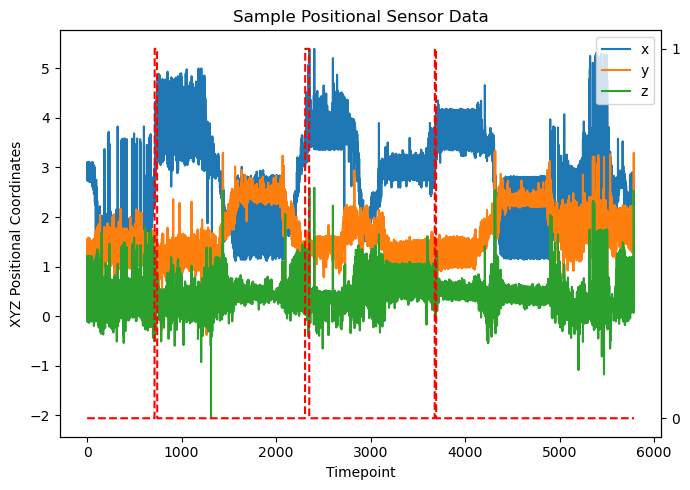

In [178]:
user_idx = 'B04'
fig, ax = plt.subplots(figsize=(7, 5), layout='tight')
ax.plot(falling_df[user_idx]['X'], label='x')
ax.plot(falling_df[user_idx]['Y'], label='y')
ax.plot(falling_df[user_idx]['Z'], label='z')

ax2 = ax.twinx()
ax2.plot(falling_df[user_idx]['Anomaly'], c='red', linestyle="dashed")
ax2.set_yticks([0, 1])

ax.set_ylabel('XYZ Positional Coordinates')
ax.set_xlabel('Timepoint')
ax.legend(loc='upper right')
ax.set_title('Sample Positional Sensor Data')



## Model Training

In [156]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit


from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder


y = removed_time_df['Activity']
X = removed_time_df.loc[:, removed_time_df.columns != 'Activity']


def ML_GridSearchCV(X, y, groups, n_folds, preprocessor, models, param_grid):
    test_scores = []
    best_models = []


    random_states = [i for i in range(5)]
    for random_state in random_states:
        print(f'Training model {random_state} out of {len(random_states)}')

        splitter = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=random_state)
        for i_other,i_test in splitter.split(X, y, groups):
            X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
            X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]

        kf = GroupKFold(n_splits=n_folds)
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', models)
        ])

        grid_search = GridSearchCV(
            estimator=pipeline, 
            param_grid=param_grid,
            scoring='recall_micro',
            return_train_score = True,
            cv=kf,
            n_jobs=-1,
            verbose=True
        )
        le = LabelEncoder()
        y_other = le.fit_transform(y_other)
        y_test = le.fit_transform(y_test)

        
        grid_search.fit(X_other, y_other, groups=groups_other)

        best_model = grid_search.best_estimator_

        print(f'Best model parameters: {grid_search.best_params_}')
        print(f'Validation score: {grid_search.best_score_}')

        best_models.append(best_model)

        y_test_pred = best_model.predict(X_test)

        print('true', list(y_test))
        print('pred', y_test_pred)
        test_rmse = recall_score(y_test, y_test_pred, average='micro')

        test_scores.append(test_rmse)

    return test_scores, best_models

onehot_features = ['Sensor Tag']
standard_features = ['X', 'Y', 'Z']
label_features = ['User']

preprocessor = ColumnTransformer(transformers=[
    ('onehot', OneHotEncoder(), onehot_features),
    ('std', StandardScaler(), standard_features),
])

param_grids = {
    "logistic": {"model__C": [0.1, 1, 10]},
    "rf": {
        "model__max_features": [0.25, 0.5, 1.0],
        "model__max_depth": [5, 10, 30],
    },
    "knn": {
        "model__n_neighbors": [1, 5, 10, 30],
        "model__weights": ["uniform", "distance"],
    },
    'xgboost': {
        "model__n_estimators": [100, 500, 1000, 2000],
        "model__max_depth": [3, 4, 5]
    }
}

models = {
    "logistic": LogisticRegression('l2', random_state=1),
    "xgboost": XGBClassifier(),
    "rf": RandomForestClassifier(random_state=1),
    "knn": KNeighborsClassifier(),
    
}

model_scores = {}

for model in models.keys():
    test_scores, best_models = ML_GridSearchCV(X, y, groups=removed_time_df['User'], n_folds=3,
                                                preprocessor=preprocessor, models=models[model],
                                                param_grid=param_grids[model])
    model_scores[model] = {'test_score': test_scores, 'best_models': best_models}

Training model 0 out of 5
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best model parameters: {'model__C': 0.1}
Validation score: 0.38856121611042066
true [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

/Users/kylelam/anaconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model parameters: {'model__max_depth': 10, 'model__max_features': 0.5}
Validation score: 0.6024095784287157
true [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4

/Users/kylelam/anaconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model parameters: {'model__max_depth': 10, 'model__max_features': 0.5}
Validation score: 0.6079813820691348
true [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

/Users/kylelam/anaconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model parameters: {'model__max_depth': 10, 'model__max_features': 0.5}
Validation score: 0.6130149967780664
true [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 

/Users/kylelam/anaconda3/envs/data1030/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model parameters: {'model__max_depth': 10, 'model__max_features': 0.25}
Validation score: 0.5943591839675268
true [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [157]:
for model in model_scores:
    score_mean = np.mean(model_scores[model]['test_score'])
    score_std = np.std(model_scores[model]['test_score'])

    print(f'{model:15} mean score: {score_mean:20}, {model:15} std score: {score_std:20}')

logistic        mean score:  0.41468755330442686, logistic        std score: 0.013269961236233287
xgboost         mean score:   0.5999217490882067, xgboost         std score: 0.015944967565475497
rf              mean score:    0.602690865650262, rf              std score: 0.013868274907387072
knn             mean score:   0.5903736561247773, knn             std score: 0.015549251684661702


In [168]:
preds = best_models[0].predict(X[X['User'] == 'A01'])
print(len(X[X['User'] == 'A01']))
le = LabelEncoder()
y_test = le.fit_transform(y)
print(y[:len(X[X['User'] == 'A01'])].unique())


print(classification_report(list(y_test)[:len(X[X['User'] == 'A01'])], preds))

5830
['walking' 'sitting down' 'sitting' 'standing up from sitting' 'falling'
 'lying' 'standing up from lying' 'lying down' 'sitting on the ground'
 'standing up from sitting on the ground' 'on all fours']
              precision    recall  f1-score   support

           0       0.50      0.07      0.13        80
           1       0.82      0.89      0.85      2184
           2       0.15      0.05      0.07       146
           3       0.73      0.39      0.51       247
           4       0.73      0.90      0.81      1007
           5       0.60      0.08      0.14        74
           6       0.86      0.97      0.91       551
           7       0.44      0.31      0.37       518
           8       0.00      0.00      0.00        42
           9       0.72      0.22      0.34       104
          10       0.65      0.74      0.69       877

    accuracy                           0.74      5830
   macro avg       0.56      0.42      0.44      5830
weighted avg       0.71      0.74  